In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

plt.style.use('default')

NUM_CLUSTERS = 7

In [39]:
df = pd.read_csv("features/features.csv", index_col=0)

In [40]:
def clean_raw_df(df: pd.DataFrame, pipe=True) -> pd.DataFrame:
    """Returns a clean version of the raw DataFrame"""
    df = df.drop_duplicates(subset=["uri"]).set_index("uri").dropna()
    if pipe:
        df = df.drop(["track_href", "id", "title", "type", "analysis_url"], axis=1)
    df = df[df['time_signature'] > 0.0]
    df = df.replace({"mode": {1.0:"major", 0.0: "minor"}})
    return df

In [41]:
def one_hot(df: pd.DataFrame) -> pd.DataFrame:
    """One hot encodes the Mode and Time Signature Features"""
    oh_enc = OneHotEncoder()
    oh_enc.fit(df[['mode', "time_signature", "key"]])
    dummies = pd.DataFrame(oh_enc.transform(df[['mode', "time_signature", "key"]]).todense(), 
                           columns=oh_enc.get_feature_names(['mode', "time_signature", "key"]),
                           index = df.index)
    return df.join(dummies).drop(['mode', "time_signature", "key"], axis=1)

In [42]:
def center(df: pd.DataFrame) -> pd.DataFrame:
    """ Returns a design matrix for PCA from a given DataFrame"""
    means = np.mean(df)
    centered = df - means
    
    return centered

In [43]:
def design_matrix(df: pd.DataFrame) -> pd.DataFrame:
    """Returns the design matric of the DataFrame"""
    return StandardScaler().fit_transform(df.to_numpy())

In [44]:
def plot_scree(df: pd.DataFrame) -> None:
    """Creates a scree plot of the singular values of the SVD"""
    u, s, vt = np.linalg.svd(design_matrix(df), full_matrices=False)
    num_features = s.shape[0] + 1
    
    plt.figure(figsize=(10,5))
    plt.plot(list(range(1,num_features)), s**2 / sum(s**2))
    plt.xticks(list(range(1, num_features)), list(range(1,num_features)))
    plt.xlabel('PC #');
    plt.ylabel('Fraction of Variance Explained');
    plt.title('Fraction of Variance Explained by each Principal Component');

In [49]:
def cluster_data(df: pd.DataFrame, clusters=NUM_CLUSTERS) -> tuple:
    X = design_matrix(df)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X)

    principal_df = pd.DataFrame(data=principal_components, columns=['PC_1', 'PC_2'])

    music_data_pca = principal_df.to_numpy()
    kmeans_pca = KMeans(n_clusters=clusters, random_state=0, init='k-means++', n_init=25).fit(music_data_pca)
    predicted_pca = kmeans_pca.fit_predict(music_data_pca)
    target_df_pca = principal_df.copy()
    target_df_pca['prediction'] = predicted_pca
    target_df_pca.set_index(keys=df.index, inplace=True)
    
    return target_df_pca, kmeans_pca

In [50]:
def plot_pca(cluster_data: tuple) -> None:
    """Plot a PCA chart with n clusters"""
    data, kmeans = cluster_data
    n = kmeans.n_clusters
    plt.figure(figsize=(10,5))
    sns.scatterplot(x='PC_1', y='PC_2', data=data, 
                    hue='prediction', palette=sns.color_palette('hls', n), 
                    style='prediction', markers=n*['.'], s=100)

    for center, i in zip(kmeans.cluster_centers_, range(n)):
        if not i:
            plt.scatter(center[0], center[1], marker='*',s=200, c='black', label='Centroid')
        else:
            plt.scatter(center[0], center[1], marker='*',s=200, c='black')

    plt.xlabel('First Principal Component (PCA)')
    plt.ylabel('Second Principal Component (PCA)')
    plt.title('k-Means Clustering via PCA', pad=20)
    plt.legend(shadow=True);

In [51]:
def pipeline(df, plot=True, return_data=False):
    """Completes a full cycle of the PCA, Clustering processs for a given DataFrame."""
    cleaned = clean_raw_df(df)
    oh = one_hot(cleaned)
    centered = center(oh)
    cluster = cluster_data(centered)
    
    if plot:
        plot_scree(centered)
        plot_pca(cluster)
    
    if return_data:
        return cluster[0], cluster[1], centered

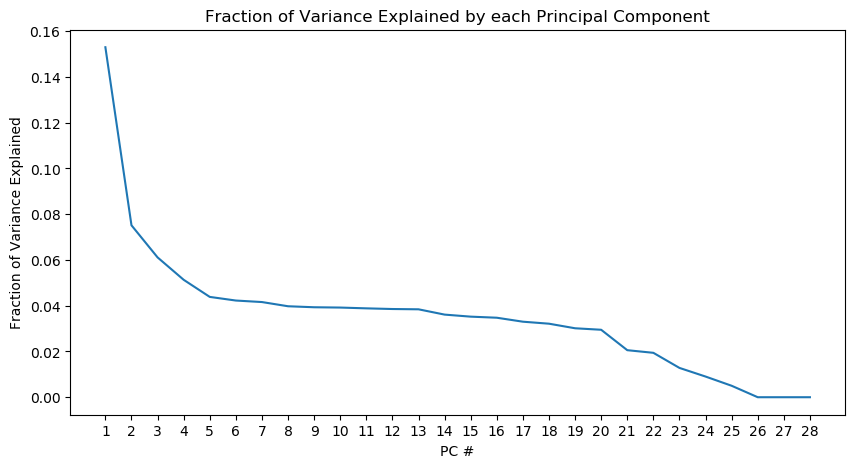

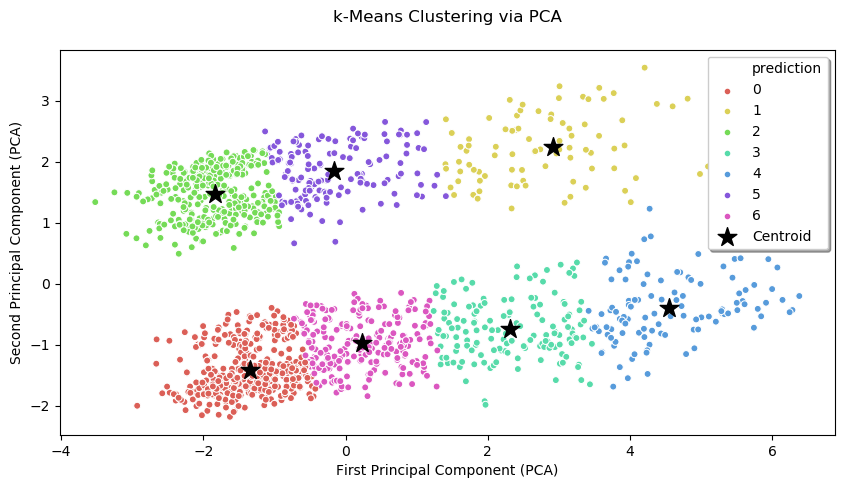

In [52]:
data, kmeans, clustered = pipeline(df, plot=True, return_data=True)

In [53]:
preds = data.merge(clean_raw_df(df, pipe=False), how="inner", 
                left_on=data.index, 
                right_on=clean_raw_df(df, pipe=False).index, 
                left_index=True, 
                right_index=True)

In [54]:
fig = px.scatter(preds, x='PC_1', y='PC_2', hover_name='title', color="prediction")
fig.update_layout(
    height=600,
    width=900,
    title_text='PCA of Spotify Tracks'
)
fig.show()